# PyTorch introduction

Example is taken from the official documentation which you can
find [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

Even though the example is long, this shouldn't discourage you,
as most of the code is repeated quite a lot, so take your time
to analyize it and understand it.

## Load required libraries

In [ ]:
import numpy as np
%matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
torch.__version__

'1.3.0+cu100'

## Example 01 - Numpy warming up

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
losses = []
for t in tqdm(range(500)):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # Compute loss
    loss = np.square(y_pred - y).sum()
    # Record loss value
    losses.append(loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

100%|██████████| 500/500 [00:01<00:00, 459.96it/s]


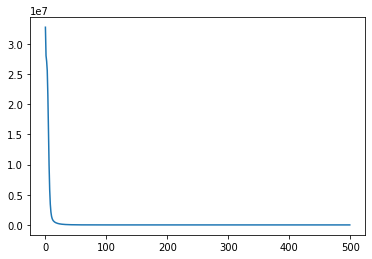

In [ ]:
plt.plot(range(500), losses)

## Example 02 - PyTorch tensors

Numpy code from previous example is given in
comments to illustrate how similar it is.

In [ ]:
device = torch.device('cpu')

# N is batch size;
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data

# (np) x = np.random.randn(N, D_in)
x = torch.randn(N, D_in, device=device)
# (nP) y = np.random.randn(N, D_out)
y = torch.randn(N, D_out, device=device)

# Randomly initialize weights
# (np) w1 = np.random.randn(D_in, H)
w1 = torch.randn(D_in, H, device=device)
# (np) w2 = np.random.randn(H, D_out)
w2 = torch.randn(H, D_out, device=device)

print(f'x.shape={x.shape}')
print(f'y.shape={y.shape}')
print(f'w1.shape={w1.shape}')
print(f'w2.shape={w2.shape}')

learning_rate = 1e-6

x.shape=torch.Size([64, 1000])
y.shape=torch.Size([64, 10])
w1.shape=torch.Size([1000, 100])
w2.shape=torch.Size([100, 10])


In [ ]:
losses = []

for t in tqdm(range(500)):
    # Prolaz unapred: izracunava se predvidjeno y
    # (np) h = x.dot(w1)
    h = x.mm(w1)
    # (np) h_relu = np.maximum(h, 0)
    h_relu = h.clamp(min=0)
    # (np) y_pred = h_relu.dot(w2)
    y_pred = h_relu.mm(w2)
    
    # Compute loss. Function `item()` is used to extract
    # a scalar value from a tensor.
    # (np) loss = np.square(y_pred - y).sum()
    loss = (y_pred - y).pow(2).sum()

    # Record loss value
    losses.append(loss.item())
    
    # Calculate gradients
    # (np) grad_y_pred = 2.0 * (y_pred - y)
    grad_y_pred = 2.0 * (y_pred - y)
    # (np) grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    # (np) grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h_relu = grad_y_pred.mm(w2.t())
    # (np) grad_h = grad_h_relu.copy()
    grad_h = grad_h_relu.clone()
    # (np) grad_h[h < 0] = 0
    grad_h[h < 0] = 0
    # (np) grad_w1 = x.T.dot(grad_h)
    grad_w1 = x.t().mm(grad_h)
    
    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

100%|██████████| 500/500 [00:00<00:00, 738.28it/s]


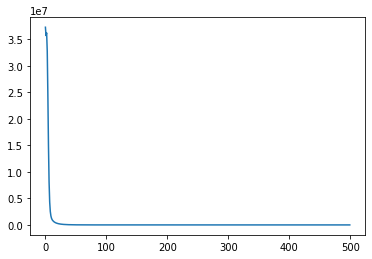

In [ ]:
plt.plot(range(500), losses)

## Example 03 - Calculating gradients using `autograd`

Obviously calculating gradients is a complex job, which is exactly
one of the reasons deep learning frameworks exist.
Torch has a module `autograd` that allows to calculate gradients
automatically.

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

dtype = torch.float
device = torch.device('cpu')
# device = torch.device('cuda:0') # uncomment for gpu support

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
losses = []

In [ ]:
for t in tqdm(range(500)):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    losses.append(loss.item())

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

100%|██████████| 500/500 [00:00<00:00, 678.72it/s]


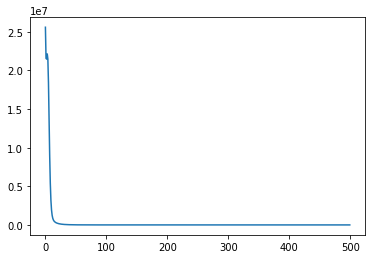

In [ ]:
plt.plot(range(500), losses)

## Example 04 - Using module `nn`

We shall rewrite the previous example now into something
that resembles a neural network much more!

If you are familiar with `keras`, torch also has a `Sequential`
wrapper that you can use.

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

In [ ]:
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

In [ ]:
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

In [ ]:
losses = []
learning_rate = 1e-4
for t in tqdm(range(500)):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    losses.append(loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

100%|██████████| 500/500 [00:00<00:00, 609.96it/s]


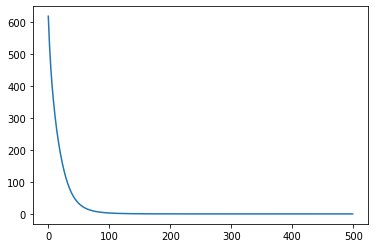

In [ ]:
plt.plot(range(500), losses)

## Example 05 - We can use `optim` module to update model parameters.

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

loss_fn = torch.nn.MSELoss(reduction='sum')

In [ ]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in tqdm(range(500)):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    losses.append(loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

100%|██████████| 500/500 [00:01<00:00, 464.54it/s]


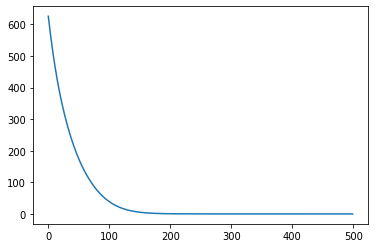

In [ ]:
plt.plot(range(500), losses)

## Example 06 - Creating a custom `nn` module

Usually in practice it's advised to construct your neural network
like this and use full OOP abstractions. When inheriting
`torch.nn.Module` class, you are required to implemented
the `forward()` function that will define the forward
pass through your network. Backward pass isn't required to be
defined as `PyTorch` will deduce the equation by itself using
`autograd` module.

In [ ]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

In [ ]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
losses = []
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in tqdm(range(500)):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    losses.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 500/500 [00:00<00:00, 725.23it/s]


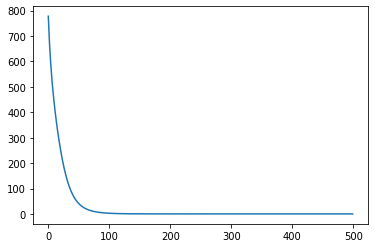

In [ ]:
plt.plot(range(500), losses)

In [ ]:
torch.nn.MSELoss()

MSELoss()